In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sympy import Circle

def get_hue_histogram(image, convert=True):
    if convert:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_channel = image[:, :, 0]
    histogram, _ = np.histogram(hue_channel, bins=100, range=(0, 180), density=True)
    histogram + histogram.astype(float) +  0.001
    return histogram / histogram.sum()


def remove_small_components(binary_image, min_size=50):
    """Remove small connected components"""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        binary_image.astype(np.uint8), connectivity=8
    )

    # Keep only components larger than min_size
    mask = np.zeros_like(binary_image, dtype=bool)
    for i in range(1, num_labels):  # Skip background (0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask[labels == i] = True

    return mask

def plot_detected_blobs(image_bgr, circles, title):
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_rgb)
    for (cx, cy, r) in circles:
        circ = Circle((cx, cy), r, fill=False, linewidth=2, color='magenta')
        inner = Circle((cx, cy), max(2, r*0.15), fill=False, linewidth=2, color='magenta')
        ax.add_patch(circ)
        ax.add_patch(inner)
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def extract_and_compare_blobs(image, template_hist, sigma_values):
    detector = create_stable_blob_detector()

    gr_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints = detector.detect(gr_image)
    detected_sunflowers = []

    for sigma in sigma_values:
        side_length = int(4 * sigma)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        for i, kp in enumerate(keypoints):
            x_start = int(kp.pt[0] - side_length // 2)
            y_start = int(kp.pt[1] - side_length // 2)
            region = image_hsv[y_start:y_start + side_length, x_start:x_start + side_length]

            blob_hist = get_hue_histogram(region, False)
            divergence = entropy(blob_hist, template_hist) # Calculate Kullback-Leibler Divergence

            if divergence < kl_divergence_threshold:
                detected_sunflowers.append((x_start, y_start, x_start + side_length, y_start + side_length, divergence))

    # Apply Non-Maximum Suppression to the combined detections
    final_detections = apply_nms(detected_sunflowers, iou_threshold=0.05)

    return final_detections

def load_true_bounding_boxes(txt_path):
    true_boxes = []
    with open(txt_path, 'r') as file:
        for line in file:
            x_start, y_start, x_end, y_end = map(int, line.strip().split())
            true_boxes.append((x_start, y_start, x_end, y_end))
    return true_boxes

def display_results(image, detected_sunflowers, true_boxes):
    image_with_true_boxes = image.copy()
    image_with_detected_boxes = image.copy()

    for (x_start, y_start, x_end, y_end) in true_boxes:
        cv2.rectangle(image_with_true_boxes, (x_start, y_start), (x_end, y_end), (255, 255, 255), 2)

    for (x_start, y_start, x_end, y_end) in detected_sunflowers:
        cv2.rectangle(image_with_detected_boxes, (x_start, y_start), (x_end, y_end), (255, 10, 232), 2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(image_with_true_boxes, cv2.COLOR_BGR2RGB))
    axes[0].set_title("True Sunflower Locations")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(image_with_detected_boxes, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Detected Sunflowers")
    axes[1].axis("off")

    plt.show()


def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1p, y1p, x2p, y2p = box2

    x_left = max(x1, x1p)
    y_top = max(y1, y1p)
    x_right = min(x2, x2p)
    y_bottom = min(y2, y2p)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2p - x1p) * (y2p - y1p)

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def calculate_precision_recall(detected_boxes, true_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0

    matched_true_boxes = set()
    for detected_box in detected_boxes:
        found_match = False
        for i, true_box in enumerate(true_boxes):
            iou = calculate_iou(detected_box, true_box)
            if iou >= iou_threshold and i not in matched_true_boxes:
                true_positives += 1
                matched_true_boxes.add(i)
                found_match = True
                break
        if not found_match:
            false_positives += 1

    false_negatives = len(true_boxes) - len(matched_true_boxes)

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall


# Non-Maximum Suppression (NMS)
def apply_nms(detections, iou_threshold):
    detections = sorted(detections, key=lambda x: x[4], reverse=False)

    filtered_boxes = []

    while detections:
        best_box = detections.pop(0)
        filtered_boxes.append(best_box)

        detections = [box for box in detections if calculate_iou(best_box[:4], box[:4]) < iou_threshold]

    # Remove the divergence score (fifth element) from each box and return only the coordinates
    return [box[:4] for box in filtered_boxes]

In [22]:
def create_stable_blob_detector():
    params = cv2.SimpleBlobDetector_Params()

    # Filter by Area - CRITICAL to set these
    params.filterByArea = True
    params.minArea = 50
    params.maxArea = 50000  # Increase for larger blobs

    # Other filters - set explicitly
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    params.filterByColor = True
    params.blobColor = 0  # 0 for dark blobs, 255 for light blobs

    # Threshold parameters
    params.minThreshold = 50
    params.maxThreshold = 200
    params.thresholdStep = 10

    # Minimum distance between blobs
    params.minDistBetweenBlobs = 10

    try:
        detector = cv2.SimpleBlobDetector_create(params)
        return detector
    except Exception as e:
        print(f"Detector creation failed: {e}")
        return None

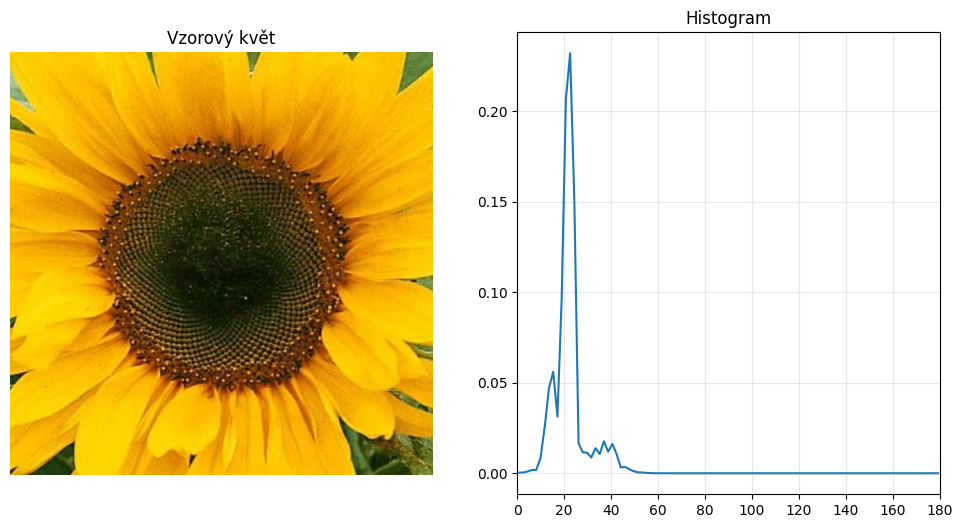

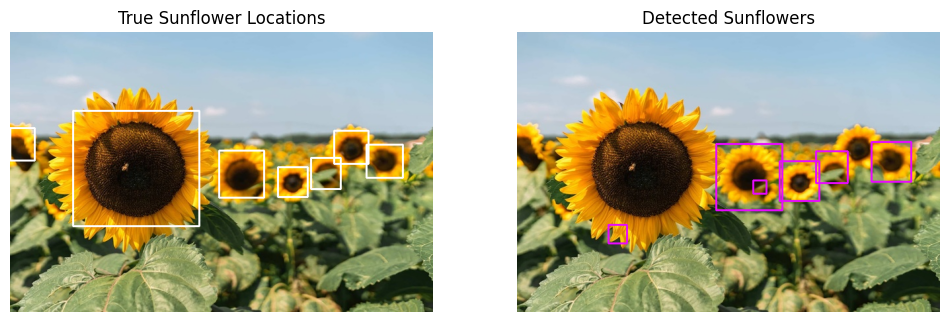

Detected regions in pvi_cv08_sunflowers1.jpg: 6
Precision: 0.50
Recall: 0.43


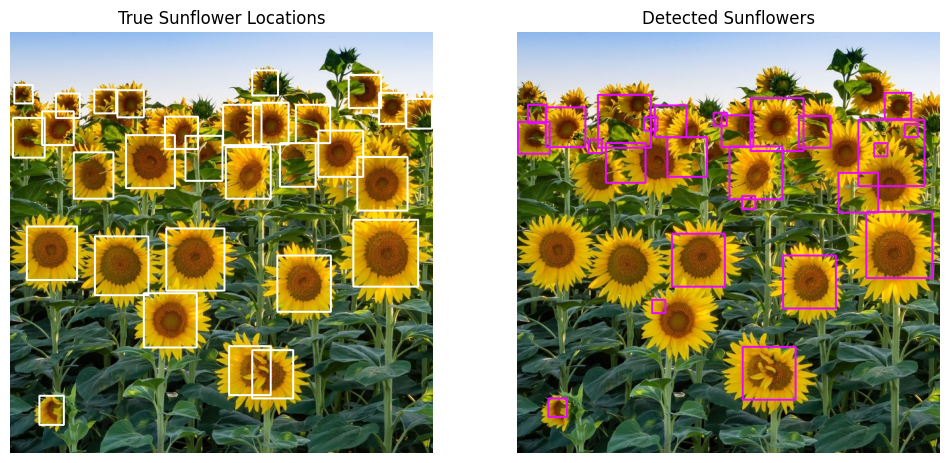

Detected regions in pvi_cv08_sunflowers2.jpg: 26
Precision: 0.35
Recall: 0.30


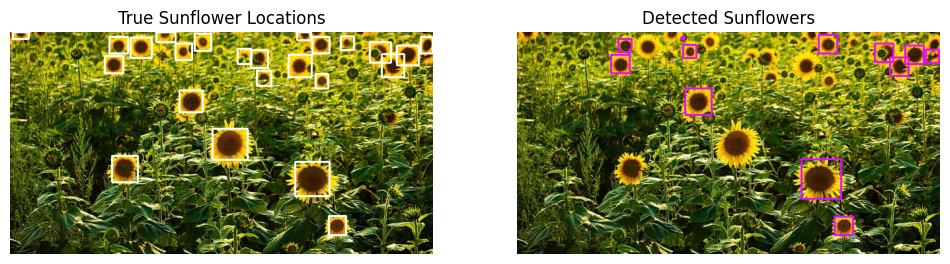

Detected regions in pvi_cv08_sunflowers3.jpg: 12
Precision: 0.83
Recall: 0.42


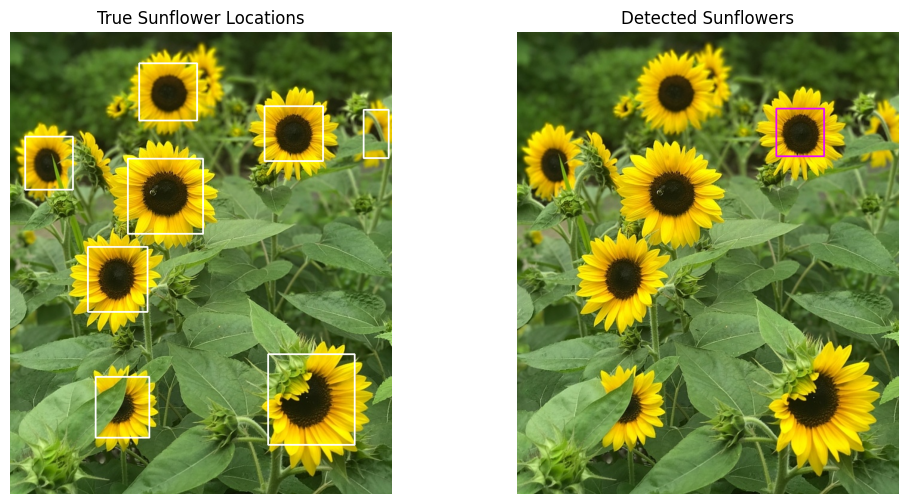

Detected regions in pvi_cv08_sunflowers4.jpg: 1
Precision: 1.00
Recall: 0.12


In [28]:
#sigma_values = [5, 10, 15, 20, 25, 40, 60]
sigma_values = [1, 5, 7, 10, 12, 15, 20, 25, 30, 40, 50, 60]
kl_divergence_threshold = 0.4

image_paths = ["pvi_cv08_sunflowers1.jpg", "pvi_cv08_sunflowers2.jpg", "pvi_cv08_sunflowers3.jpg",
               "pvi_cv08_sunflowers4.jpg"]
template_path = "pvi_cv08_sunflower_template.jpg"

template_image = cv2.imread(template_path)
template_hist = get_hue_histogram(template_image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Vzorový květ")
axes[0].axis("off")

bins = len(template_hist)
bin_width = 180 / bins
x = np.linspace(0, 180 - bin_width, bins) + bin_width / 2

axes[1].plot(x, template_hist)
axes[1].set_title("Histogram")
axes[1].set_xlim(0, 180)
axes[1].grid(alpha=0.3)

plt.show()

for path in image_paths:
    img = cv2.imread(path)
    detected_sunflowers = extract_and_compare_blobs(img, template_hist, sigma_values)
    txt_path = path.replace('.jpg', '.txt')
    true_boxes = load_true_bounding_boxes(txt_path)

    display_results(img, detected_sunflowers, true_boxes)
    precision, recall = calculate_precision_recall(detected_sunflowers, true_boxes, iou_threshold=0.5)
    print(f"Detected regions in {path}: {len(detected_sunflowers)}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")